In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde, pearsonr, probplot
from collections import Counter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# %%

In [19]:
ccle = pd.read_csv('../data/processed/ccle/merged_data.csv', index_col=0)

# Cancer Cell Line Encyclopedia (CCLE) Overview

The Cancer Cell Line Encyclopedia (CCLE) is a collaborative project between the Broad Institute and Novartis Institutes for Biomedical Research. It provides a comprehensive genetic, transcriptomic, and pharmacologic characterization of over 1,000 human cancer cell lines. CCLE serves as a foundational resource for cancer research, enabling the study of cancer biology, drug response, and biomarker discovery in a controlled, reproducible setting. The dataset includes mutation profiles, gene expression, copy number variation, and drug sensitivity data, making it a powerful tool for integrative analyses and predictive modeling in oncology.

## About This Notebook

This notebook explores the CCLE dataset, focusing on mutation types, feature distributions, and statistical analyses. We use a variety of plots and statistical tests to understand the landscape of mutations and gene expression in cancer cell lines, and to identify features relevant to TP53 mutation status.

## Mutation Types

We provide a summary of mutation types present in the dataset:

| Label        | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| **SNV**      | *Single Nucleotide Variant* — A change in a single base pair in the DNA.   |
| **Deletion** | One or more nucleotides are removed from the DNA sequence.                 |
| **Insertion**| One or more nucleotides are added to the DNA sequence.                     |
| **None**     | No mutation detected.                                                      |
| **Substitution** | One segment of DNA is replaced with a different sequence.              |

This classification helps in downstream analyses of mutation impact and distribution.

In [20]:
# Map numeric VariantType to class labels
label_map = {0: 'nan', 1: 'SNV', 2: 'deletion', 3: 'insertion', 4: 'substitution'}
ccle['VariantLabel'] = ccle['VariantType'].map(label_map)
feature_cols = [c for c in ccle.columns if c not in ['VariantType', 'Mutated', 'ModelID', 'VariantLabel']]


In [21]:
# Display basic info about the dataset
print("=== CCLE Dataset Overview ===")
print(f"Total samples: {len(ccle)}")
print(f"Total features: {len(feature_cols)}")


=== CCLE Dataset Overview ===
Total samples: 1795
Total features: 19193


## 2. Distribution Analysis

We analyze the distribution of mutation status and variant types across the cell lines:
- **Bar and Pie Charts:** Visualize the proportion and count of mutated vs. non-mutated samples, and the distribution of different mutation types.
- **Interpretation:** These plots help assess class balance and the prevalence of each mutation type, which is crucial for downstream statistical modeling and machine learning.

In [22]:
# how many mutaded vs non-mutated samples
print("Distribution of 'Mutated' column:")
mutated_counts = ccle['Mutated'].value_counts().sort_index()
print(f"Non-mutated (0): {mutated_counts.get(0, 0)} samples ({mutated_counts.get(0, 0)/len(ccle)*100:.1f}%)")
print(f"Mutated (1): {mutated_counts.get(1, 0)} samples ({mutated_counts.get(1, 0)/len(ccle)*100:.1f}%)")

Distribution of 'Mutated' column:
Non-mutated (0): 687 samples (38.3%)
Mutated (1): 1108 samples (61.7%)


### 2.1 Mutation Status Distribution

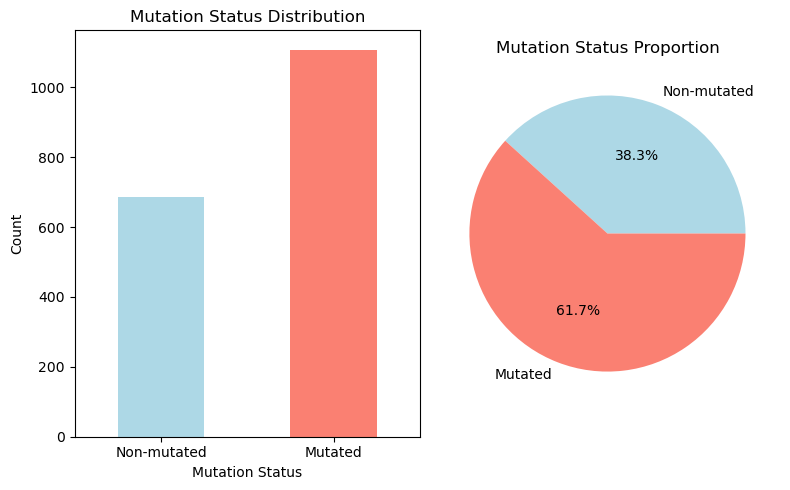

In [23]:
# Visualize mutation distribution
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
mutated_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Mutation Status Distribution')
plt.xlabel('Mutation Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-mutated', 'Mutated'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(mutated_counts.values, labels=['Non-mutated', 'Mutated'], autopct='%1.1f%%', 
        colors=['lightblue', 'salmon'])
plt.title('Mutation Status Proportion')

plt.tight_layout()
plt.show()




Distribution of 'VariantType' column:
VariantType 0: 932 samples (51.9%)
VariantType 1: 125 samples (7.0%)
VariantType 2: 33 samples (1.8%)
VariantType 3: 687 samples (38.3%)
VariantType 4: 18 samples (1.0%)


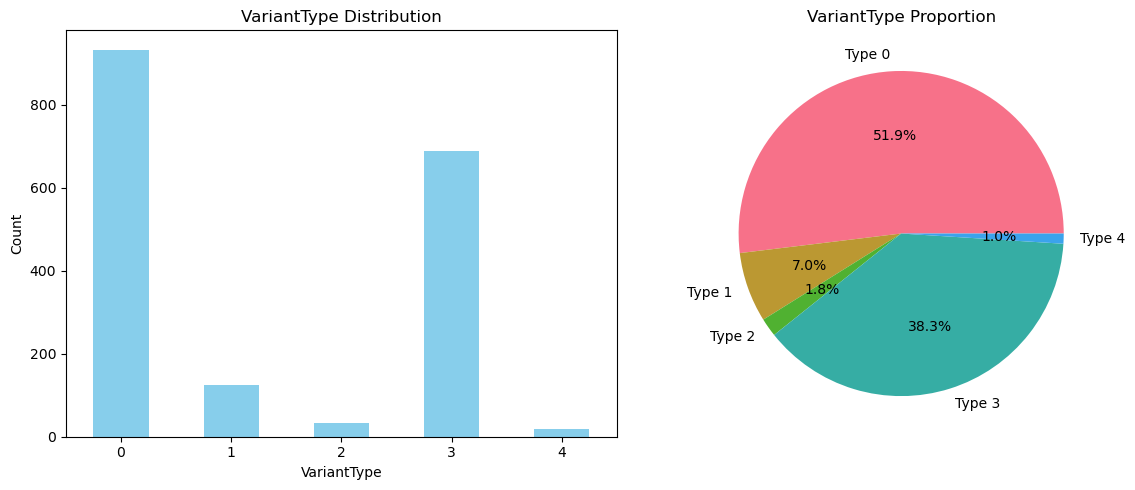

In [24]:
# Count samples for each class in 'VariantType' column
print("\nDistribution of 'VariantType' column:")
variant_counts = ccle['VariantType'].value_counts().sort_index()
total_samples = len(ccle)

for variant_type in range(5):  # 0 to 4
    count = variant_counts.get(variant_type, 0)
    percentage = (count / total_samples) * 100
    print(f"VariantType {variant_type}: {count} samples ({percentage:.1f}%)")

# Visualize variant type distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
variant_counts.plot(kind='bar', color='skyblue')
plt.title('VariantType Distribution')
plt.xlabel('VariantType')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(variant_counts.values, labels=[f'Type {i}' for i in variant_counts.index], 
        autopct='%1.1f%%')
plt.title('VariantType Proportion')

plt.tight_layout()
plt.show()

## 3. Feature Analysis and Distributions

We examine the distribution of gene expression features across samples and mutation types:
- **Histogram and Density Plots:** Show the distribution of mean feature values per sample, both overall and stratified by mutation type or status.
- **Box Plots:** Summarize the spread and central tendency of feature means, highlighting outliers and differences between groups.
- **Q-Q Plots:** Assess normality of the data, which is important for choosing appropriate statistical tests.
- **Violin Plots:** Combine box plot and density information to visualize the full distribution of feature means by mutation type.

These visualizations provide insights into the variability and structure of the data, and help identify potential batch effects or group differences.

### 3.1 Overall Dataset Distribution

In [25]:
# Calculate mean of all features for each sample
sample_means = ccle[feature_cols].mean(axis=1)
sample_stds = ccle[feature_cols].std(axis=1)

print(f"Sample statistics (mean of features per sample):")
print(f"Mean: {sample_means.mean():.6f}")
print(f"Std: {sample_means.std():.6f}")
print(f"Min: {sample_means.min():.6f}")
print(f"Max: {sample_means.max():.6f}")


Sample statistics (mean of features per sample):
Mean: 2.604819
Std: 0.218744
Min: 1.043332
Max: 3.255261


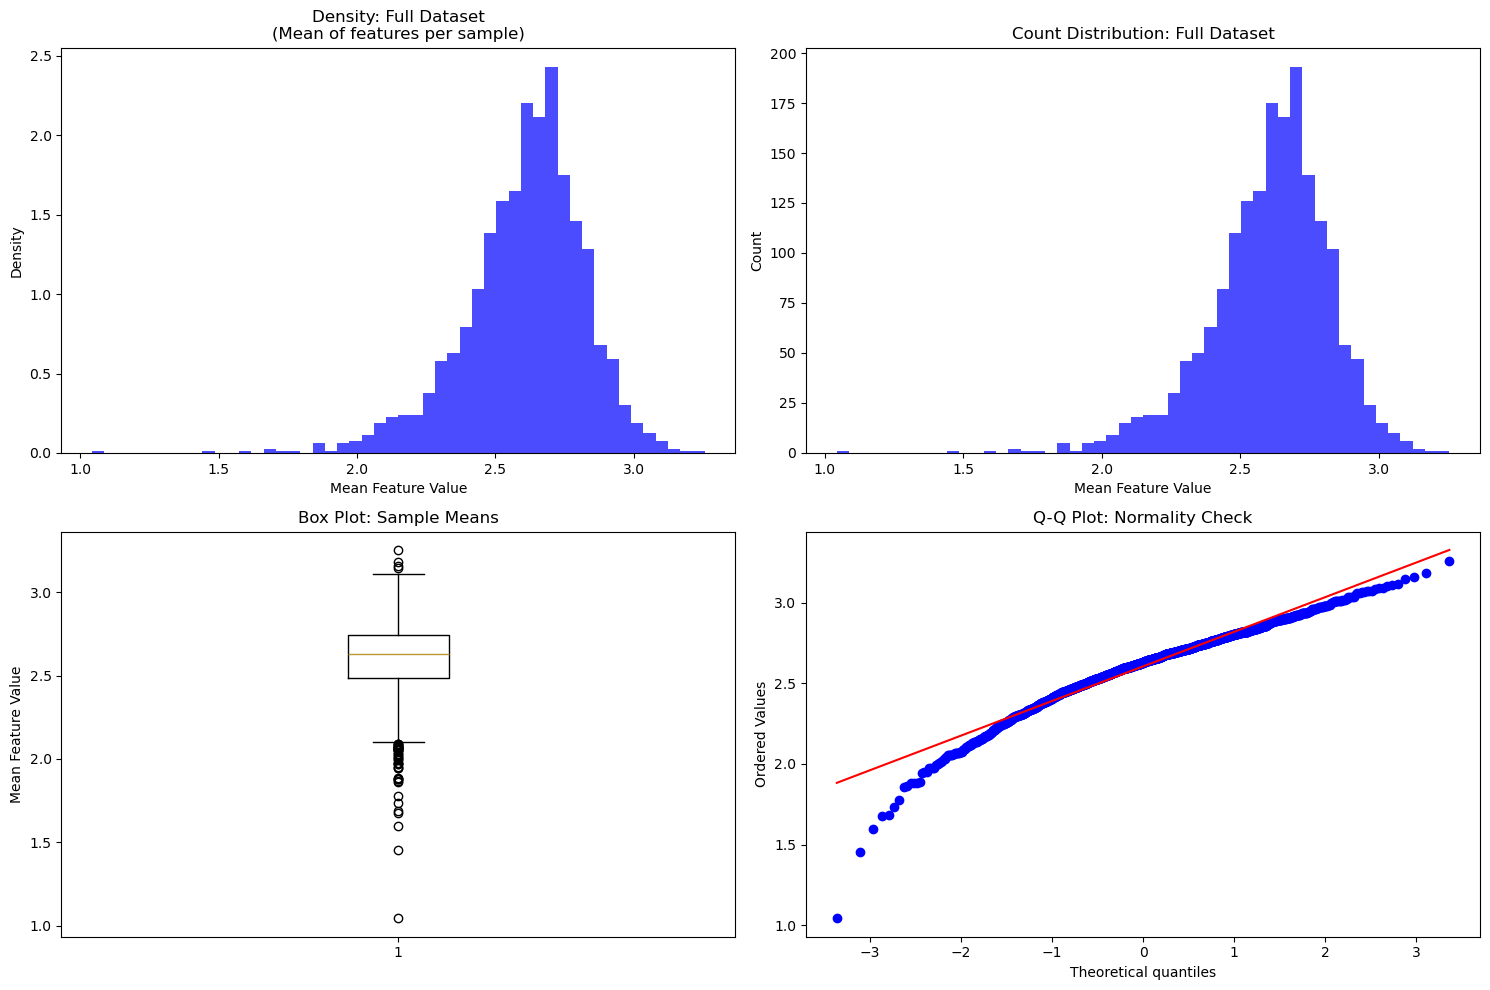

In [26]:

# Plot overall distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Density plot of full dataset
axes[0, 0].hist(sample_means, bins=50, alpha=0.7, color='blue', density=True)
axes[0, 0].set_title('Density: Full Dataset\n(Mean of features per sample)')
axes[0, 0].set_xlabel('Mean Feature Value')
axes[0, 0].set_ylabel('Density')

# Probability distribution of full dataset
axes[0, 1].hist(sample_means, bins=50, alpha=0.7, color='blue')
axes[0, 1].set_title('Count Distribution: Full Dataset')
axes[0, 1].set_xlabel('Mean Feature Value')
axes[0, 1].set_ylabel('Count')

# Box plot
axes[1, 0].boxplot(sample_means)
axes[1, 0].set_title('Box Plot: Sample Means')
axes[1, 0].set_ylabel('Mean Feature Value')

# Q-Q plot for normality check
probplot(sample_means, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Normality Check')

plt.tight_layout()
plt.show()

## Key Takeaways

Based on per-sample mean feature values (density peak ~2.7, box plot IQR ~2.5–2.7, Q–Q mild upper‐tail deviation):

- **Consistent Main Group**  
  Most samples cluster tightly around the center (histogram peak, box plot), showing a stable baseline that simplifies downstream modeling and comparison.

- **Distinctive Subsets**  
  A small set of samples extend below ~2.0 or above ~3.0 (histogram tails, box plot outliers). These represent natural variation that could uncover unique subpopulations or signals.

- **Mild Positive Skew**  
  The Q–Q plot shows the upper tail slightly above the normal line (observed > theoretical), indicating a subgroup with higher mean values. This reflects useful heterogeneity in the dataset.

### 3.2 Distributions by VariantType

We analyze distributions by VariantType using various plots:
- **Density and Count Histograms:** Show the distribution of mean feature values for each VariantType, allowing comparison of expression profiles.
- **Box and Violin Plots:** Summarize the distribution of feature means, highlighting differences between VariantTypes.

These analyses help understand how different mutation types affect gene expression and identify VariantTypes with distinct expression patterns.

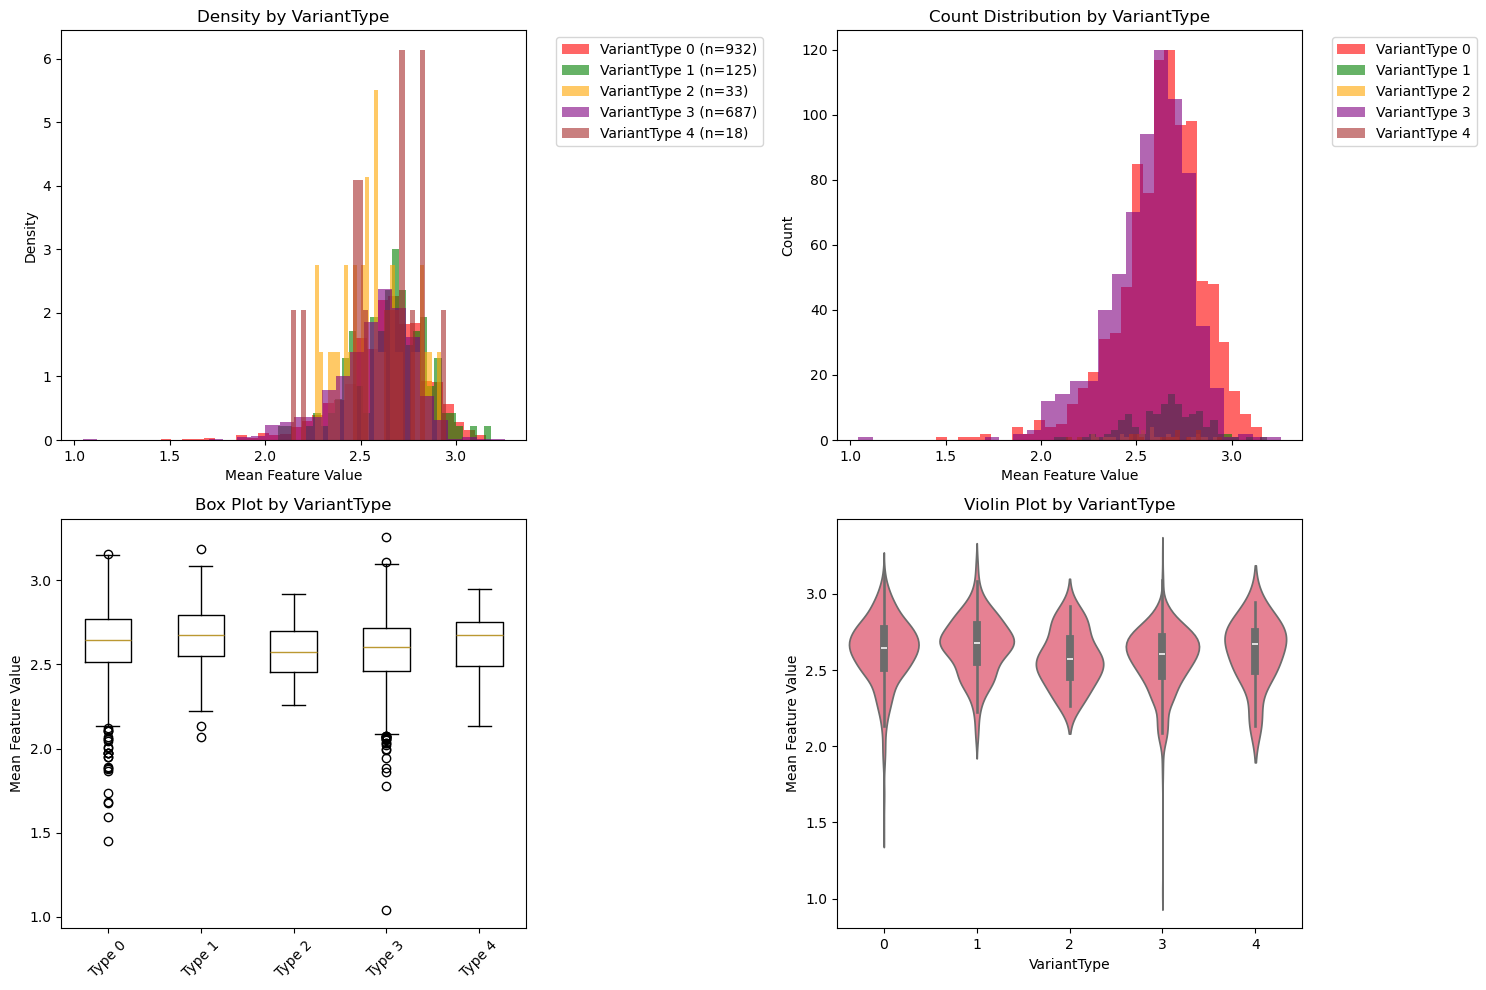

In [27]:
# Analyze distributions by VariantType
plt.figure(figsize=(15, 10))

colors = ['red', 'green', 'orange', 'purple', 'brown', 'pink']

# Density plot by VariantType
plt.subplot(2, 2, 1)
for i, variant_type in enumerate(sorted(ccle['VariantType'].unique())):
    subset = ccle[ccle['VariantType'] == variant_type]
    if len(subset) > 0:
        subset_means = subset[feature_cols].mean(axis=1)
        plt.hist(subset_means, bins=30, alpha=0.6, 
                label=f'VariantType {variant_type} (n={len(subset)})',
                color=colors[i % len(colors)], density=True)

plt.title('Density by VariantType')
plt.xlabel('Mean Feature Value')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Count distribution by VariantType
plt.subplot(2, 2, 2)
for i, variant_type in enumerate(sorted(ccle['VariantType'].unique())):
    subset = ccle[ccle['VariantType'] == variant_type]
    if len(subset) > 0:
        subset_means = subset[feature_cols].mean(axis=1)
        plt.hist(subset_means, bins=30, alpha=0.6, 
                label=f'VariantType {variant_type}',
                color=colors[i % len(colors)])

plt.title('Count Distribution by VariantType')
plt.xlabel('Mean Feature Value')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Box plot by VariantType
plt.subplot(2, 2, 3)
variant_data = []
variant_labels = []
for variant_type in sorted(ccle['VariantType'].unique()):
    subset = ccle[ccle['VariantType'] == variant_type]
    if len(subset) > 0:
        subset_means = subset[feature_cols].mean(axis=1)
        variant_data.append(subset_means)
        variant_labels.append(f'Type {variant_type}')

plt.boxplot(variant_data, labels=variant_labels)
plt.title('Box Plot by VariantType')
plt.ylabel('Mean Feature Value')
plt.xticks(rotation=45)

# Violin plot by VariantType
plt.subplot(2, 2, 4)
# Create a dataframe for seaborn
plot_data = []
for variant_type in sorted(ccle['VariantType'].unique()):
    subset = ccle[ccle['VariantType'] == variant_type]
    if len(subset) > 0:
        subset_means = subset[feature_cols].mean(axis=1)
        for mean_val in subset_means:
            plot_data.append({'VariantType': variant_type, 'MeanValue': mean_val})

plot_df = pd.DataFrame(plot_data)
sns.violinplot(data=plot_df, x='VariantType', y='MeanValue')
plt.title('Violin Plot by VariantType')
plt.ylabel('Mean Feature Value')

plt.tight_layout()
plt.show()


These plots indicate that each VariantType’s per-sample mean feature values form clear, consistent distributions with expected central tendencies and limited extreme outliers, suggesting that the dataset is well-behaved and ready for reliable downstream analysis. 

### 3.3 Distributions by Mutation Status

We analyze distributions by mutation status (mutated vs. non-mutated) using various plots:
- **Density and Count Histograms:** Compare the distribution of mean feature values between mutated and non-mutated samples.
- **Box and Scatter Plots:** Visualize the spread and central tendency of feature means, highlighting potential differences.
- **KDE Plots:** Estimate the probability density function of the feature means for each group.

These analyses help identify expression features that differ significantly between mutated and non-mutated samples, providing insights into the impact of mutations on gene expression.

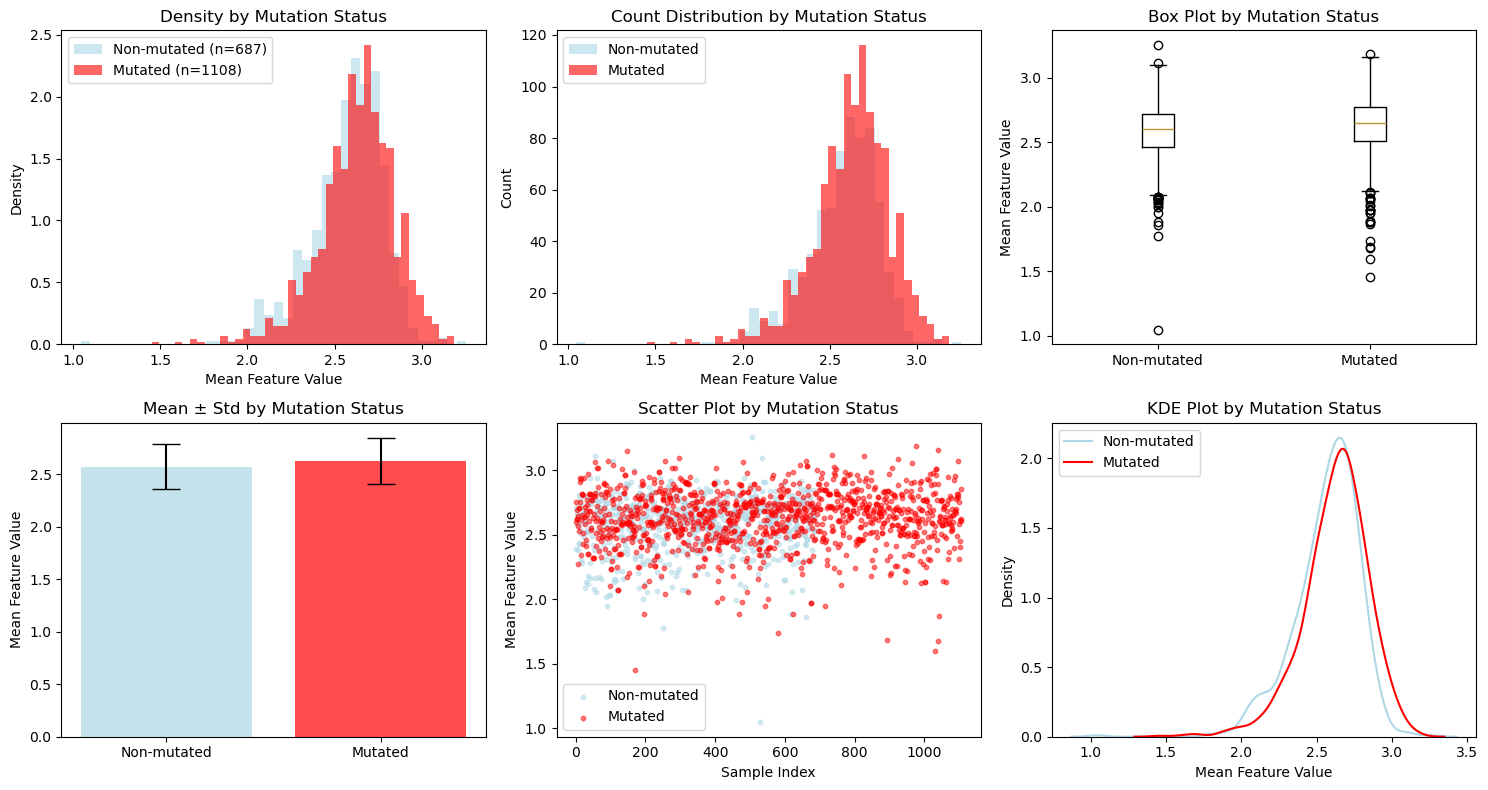

In [30]:
# Analyze distributions by mutation status
non_mutated = ccle[ccle['Mutated'] == 0]
mutated = ccle[ccle['Mutated'] == 1]

plt.figure(figsize=(15, 8))

if len(non_mutated) > 0 and len(mutated) > 0:
    non_mut_means = non_mutated[feature_cols].mean(axis=1)
    mut_means = mutated[feature_cols].mean(axis=1)
    
    # Density plot by mutation status
    plt.subplot(2, 3, 1)
    plt.hist(non_mut_means, bins=40, alpha=0.6, label=f'Non-mutated (n={len(non_mutated)})', 
             color='lightblue', density=True)
    plt.hist(mut_means, bins=40, alpha=0.6, label=f'Mutated (n={len(mutated)})', 
             color='red', density=True)
    plt.title('Density by Mutation Status')
    plt.xlabel('Mean Feature Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Count distribution by mutation status
    plt.subplot(2, 3, 2)
    plt.hist(non_mut_means, bins=40, alpha=0.6, label='Non-mutated', 
             color='lightblue')
    plt.hist(mut_means, bins=40, alpha=0.6, label='Mutated', 
             color='red')
    plt.title('Count Distribution by Mutation Status')
    plt.xlabel('Mean Feature Value')
    plt.ylabel('Count')
    plt.legend()
    
    # Box plot comparison
    plt.subplot(2, 3, 3)
    plt.boxplot([non_mut_means, mut_means], labels=['Non-mutated', 'Mutated'])
    plt.title('Box Plot by Mutation Status')
    plt.ylabel('Mean Feature Value')
    
    # Statistical comparison
    plt.subplot(2, 3, 4)
    means = [non_mut_means.mean(), mut_means.mean()]
    stds = [non_mut_means.std(), mut_means.std()]
    labels = ['Non-mutated', 'Mutated']
    
    plt.bar(labels, means, yerr=stds, capsize=10, alpha=0.7, 
            color=['lightblue', 'red'])
    plt.title('Mean ± Std by Mutation Status')
    plt.ylabel('Mean Feature Value')
    
    # Scatter plot
    plt.subplot(2, 3, 5)
    plt.scatter(range(len(non_mut_means)), non_mut_means, alpha=0.5, 
                label='Non-mutated', color='lightblue', s=10)
    plt.scatter(range(len(mut_means)), mut_means, alpha=0.5, 
                label='Mutated', color='red', s=10)
    plt.title('Scatter Plot by Mutation Status')
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Feature Value')
    plt.legend()
    
    # KDE plot
    plt.subplot(2, 3, 6)
    sns.kdeplot(non_mut_means, label='Non-mutated', color='lightblue')
    sns.kdeplot(mut_means, label='Mutated', color='red')
    plt.title('KDE Plot by Mutation Status')
    plt.xlabel('Mean Feature Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

### 3.4 Statistical Testing

We perform statistical comparisons between mutated and non-mutated groups:
- **T-test:** A parametric test to compare the means of two groups, assuming normality.
- **Mann-Whitney U test:** A non-parametric alternative that compares the distributions of two groups without assuming normality.

The results indicate whether there are significant differences in gene expression profiles between mutated and non-mutated cell lines, guiding further biological interpretation and feature selection.

In [31]:
# Perform statistical tests
if len(non_mutated) > 0 and len(mutated) > 0:
    print("=== Statistical Comparison: Mutated vs Non-mutated ===")
    print(f"Non-mutated samples: {len(non_mutated)}")
    print(f"Mean feature value: {non_mut_means.mean():.6f} ± {non_mut_means.std():.6f}")
    print(f"Median: {non_mut_means.median():.6f}")
    
    print(f"\nMutated samples: {len(mutated)}")
    print(f"Mean feature value: {mut_means.mean():.6f} ± {mut_means.std():.6f}")
    print(f"Median: {mut_means.median():.6f}")
    
    # Statistical tests
    t_stat, t_p_value = stats.ttest_ind(non_mut_means, mut_means)
    u_stat, u_p_value = stats.mannwhitneyu(non_mut_means, mut_means, alternative='two-sided')
    
    print(f"\n=== Statistical Tests ===")
    print(f"T-test (parametric):")
    print(f"  t-statistic: {t_stat:.6f}")
    print(f"  p-value: {t_p_value:.6f}")
    print(f"  Significant difference: {'Yes' if t_p_value < 0.05 else 'No'}")
    
    print(f"\nMann-Whitney U test (non-parametric):")
    print(f"  U-statistic: {u_stat:.6f}")
    print(f"  p-value: {u_p_value:.6f}")
    print(f"  Significant difference: {'Yes' if u_p_value < 0.05 else 'No'}")


=== Statistical Comparison: Mutated vs Non-mutated ===
Non-mutated samples: 687
Mean feature value: 2.570064 ± 0.214107
Median: 2.603998

Mutated samples: 1108
Mean feature value: 2.626369 ± 0.218909
Median: 2.648679

=== Statistical Tests ===
T-test (parametric):
  t-statistic: -5.341126
  p-value: 0.000000
  Significant difference: Yes

Mann-Whitney U test (non-parametric):
  U-statistic: 322286.000000
  p-value: 0.000000
  Significant difference: Yes


This tests show that mutated samples have a slightly higher average feature value. Both the two-sample t-test (t = −5.341, p < 0.0001) and the Mann–Whitney U test (U = 322,286, p < 0.0001) confirm this difference is statistically significant, indicating a consistent upward shift in the feature distribution for mutated samples.

## 4. Feature Filtration and Gene Selection

We apply feature selection techniques to focus on the most informative genes:
- **Variance Filtering:** Removes features with low variance, which are unlikely to be informative for classification or clustering.
- **IQR-Based Filtering:** Excludes features with excessive outliers, improving robustness and model performance.
- **TP53-Related Gene Selection:** Focuses on genes known to interact with or influence TP53, a key tumor suppressor gene frequently mutated in cancer.

These steps reduce dimensionality, enhance interpretability, and improve the quality of downstream analyses.

 ### 4.1 Mean and Variance of Features

Variance filtering removes features whose variance across samples is too low to be informative. 

Low‐variance features:

1. Contribute little signal
If a feature hardly changes across your dataset, you can’t rely on it to help distinguish between conditions or classes.

2. Often represent noise or off‐target measurements
Constant or near‐constant features may reflect background noise, batch effects, or failed probes.

3. Speed up downstream analyses
By dropping “flat” features, you shrink the size of your data matrix, making PCA, clustering, or model training faster and more stable.

4. Improve model performance
Many machine‐learning algorithms (e.g. Lasso, random forests) benefit from removing uninformative variables; fewer useless features often means less overfitting and better generalization.

In [54]:
feature_cols = [c for c in ccle.columns if c not in ['VariantType', 'Mutated', 'ModelID', 'VariantLabel', 'zero_count']]


In [90]:
def filter_by_variance(ccle, feature_cols, threshold_percentile=25):
    # Extract data and compute per-feature mean & variance
    feature_data  = ccle[feature_cols]
    feature_means = feature_data.mean()
    feature_vars  = feature_data.var()
    print(f"Features before variance filtration: {len(feature_cols)}")

    # Mask out NaN or zero variances
    valid_mask   = ~(feature_vars.isna() | (feature_vars == 0))
    means_valid  = feature_means[valid_mask]
    vars_valid   = feature_vars[valid_mask]
    
    # Compute the variance threshold at the given percentile
    var_threshold = np.percentile(vars_valid, threshold_percentile)
    print(f"{threshold_percentile}th percentile variance threshold: {var_threshold:.6f}")
    
    # Determine which features survive the filter
    high_var_mask = vars_valid > var_threshold
    high_var_feats = vars_valid[high_var_mask].index
    print(f"Features after variance filtration: {len(high_var_feats)}")
    
    # Plot BEFORE filtering
    plt.figure(figsize=(6,5))
    plt.scatter(means_valid, vars_valid, alpha=0.6)
    plt.axhline(var_threshold, color='gray', linestyle='--',
                label=f'{threshold_percentile}th pct cutoff')
    plt.xlabel('Feature Mean')
    plt.ylabel('Feature Variance')
    plt.title('Before Variance Filtering')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot AFTER filtering
    plt.figure(figsize=(6,5))
    plt.scatter(means_valid[high_var_mask],
                vars_valid[high_var_mask],
                alpha=0.6, color='orange')
    plt.axhline(var_threshold, color='gray', linestyle='--',
                label=f'{threshold_percentile}th pct cutoff')
    plt.xlabel('Feature Mean')
    plt.ylabel('Feature Variance')
    plt.title('After Variance Filtering')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return filtered DataFrame
    filtered = ccle[['VariantType', 'Mutated', 'ModelID', 'VariantLabel'] + list(high_var_feats)]
    return filtered

Features before variance filtration: 19193
25th percentile variance threshold: 0.372553
Features after variance filtration: 14394


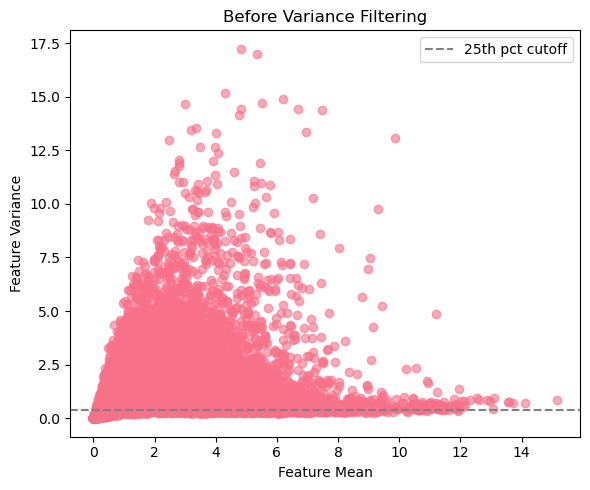

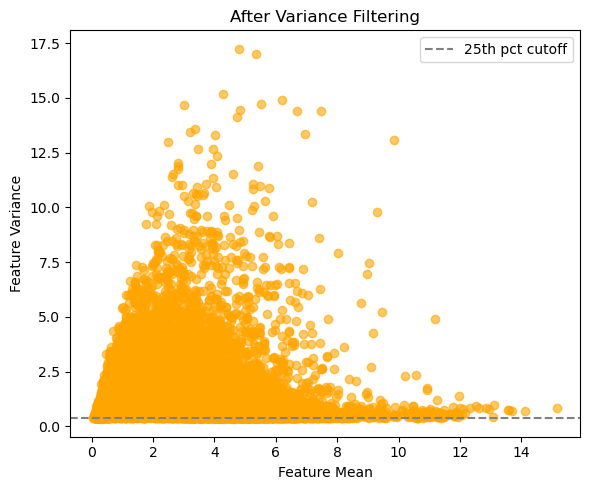

,VariantType,Mutated,ModelID,VariantLabel,TSPAN6,DPM1,C1orf112,FGR,CFH,FUCA2,...,POLR2J3,NOTCH2NLB,ASDURF,DERPC,AC055839.2,NOTCH2NLC,AP001453.3,H3C2,H3C3,DUS4L-BCAP29
0,0,1,ACH-001113,SNV,4.331992,7.364660,4.471187,0.028569,1.226509,3.044394,...,5.612352,1.176323,2.981853,4.606442,2.253989,2.587365,2.179511,2.689299,0.189034,2.130931
1,3,0,ACH-001289,none,4.567424,7.106641,3.504620,0.000000,0.189034,3.813525,...,4.733354,3.713696,3.070389,4.323370,5.827057,5.428611,2.829850,1.286881,1.049631,1.464668
2,0,1,ACH-001339,SNV,3.150560,7.379118,4.228049,0.056584,1.310340,6.687201,...,4.807355,2.722466,1.521051,3.855990,0.594549,3.665620,1.744161,0.594549,1.097611,2.946731
3,3,0,ACH-001979,none,4.240314,5.681168,1.641546,0.000000,7.236301,5.948367,...,4.837439,0.250962,2.608809,4.703211,1.232661,2.260026,2.269033,0.000000,0.000000,1.887525
4,3,0,ACH-002438,none,4.032101,6.674687,3.003602,0.000000,2.169925,6.838195,...,2.867896,1.782409,1.773996,4.135863,2.570463,2.881665,3.452859,0.238787,0.378512,1.748461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,1,1,ACH-000285,deletion,0.056584,6.604368,4.973152,0.411426,0.097611,0.704872,...,6.325530,3.044394,0.411426,4.381975,1.448901,2.733354,2.669027,2.229588,0.084064,3.039138
1791,0,1,ACH-002669,SNV,3.111031,7.031329,3.664483,0.014355,3.624101,6.805421,...,5.073392,2.495695,2.839960,3.848998,0.124328,4.735522,1.321928,0.189034,0.400538,1.327687
1792,0,1,ACH-001858,SNV,4.390943,7.013239,3.252476,0.028569,3.286881,6.902194,...,4.486714,4.822220,1.604071,3.206331,2.604071,4.324091,3.602884,1.097611,0.400538,1.992768
1793,0,1,ACH-001997,SNV,5.057450,7.815191,3.893362,0.028569,4.079805,6.971659,...,4.595146,2.653060,2.169925,4.241077,0.097611,2.545968,3.795975,0.831877,0.847997,2.153805


In [91]:
filtered_var = filter_by_variance(ccle, feature_cols)
filtered_var

In [92]:
filtered_var.to_csv('../data/processed/ccle_variance_filtered.csv', index=False)


 ### 4.2 Quantiles of Features

IQR-Based Feature Filtering
This function removes features (columns) with too many extreme values, identifying outliers as values outside the IQR range (Q1−1.5×IQR, Q3+1.5×IQR).
Features are kept only if the proportion of outliers is below a set threshold (10%).
It's useful for eliminating noisy, unstable features that could degrade model performance or skew analysis.

In [93]:
def filter_by_IQR(ccle, feature_cols, iqr_multiplier=1.5, max_outlier_fraction=0.10):
  
    #iqr_multiplier: How far from the IQR a value must be to be considered an outlier (default: 1.5)
    #max_outlier_fraction: Maximum allowed fraction of outliers per feature (default: 0.25)

    feature_data = ccle[feature_cols]
    keep = []

    # Compute IQR bounds for each feature
    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    for col in feature_data.columns:
        col_data = feature_data[col]
        outliers = (col_data < lower_bound[col]) | (col_data > upper_bound[col])
        num_outliers = outliers.sum()
        total = col_data.notna().sum()

        if total == 0:
            continue  # Skip features with all NaNs

        outlier_fraction = num_outliers / total

        if outlier_fraction <= max_outlier_fraction:
            keep.append(col)

    print(f"Features before IQR filtering: {len(feature_cols)}")
    print(f"Features after IQR filtering:  {len(keep)}")

    return ccle[['VariantType', 'Mutated', 'ModelID', 'VariantLabel'] + keep]


In [94]:
filtered_quant = filter_by_IQR(ccle, feature_cols)
filtered_quant

Features before IQR filtering: 19193
Features after IQR filtering:  14747


,VariantType,Mutated,ModelID,VariantLabel,DPM1,SCYL3,C1orf112,CFH,GCLC,NFYA,...,DERPC,AC055839.2,NOTCH2NLC,SPDYE11,AP001453.3,H3C2,H3C3,AC098582.1,DUS4L-BCAP29,C8orf44-SGK3
0,0,1,ACH-001113,SNV,7.364660,2.792855,4.471187,1.226509,6.500005,4.739848,...,4.606442,2.253989,2.587365,0.000000,2.179511,2.689299,0.189034,0.201634,2.130931,0.555816
1,3,0,ACH-001289,none,7.106641,2.543496,3.504620,0.189034,4.221877,3.481557,...,4.323370,5.827057,5.428611,0.000000,2.829850,1.286881,1.049631,0.321928,1.464668,0.632268
2,0,1,ACH-001339,SNV,7.379118,2.333424,4.228049,1.310340,3.682573,3.273516,...,3.855990,0.594549,3.665620,0.000000,1.744161,0.594549,1.097611,0.831877,2.946731,0.475085
3,3,0,ACH-001979,none,5.681168,2.063503,1.641546,7.236301,4.596935,2.918386,...,4.703211,1.232661,2.260026,0.000000,2.269033,0.000000,0.000000,0.847997,1.887525,0.176323
4,3,0,ACH-002438,none,6.674687,2.117695,3.003602,2.169925,3.253989,4.276497,...,4.135863,2.570463,2.881665,0.000000,3.452859,0.238787,0.378512,0.584963,1.748461,0.839960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,1,1,ACH-000285,deletion,6.604368,3.266037,4.973152,0.097611,4.829850,5.178715,...,4.381975,1.448901,2.733354,0.056584,2.669027,2.229588,0.084064,1.310340,3.039138,0.344828
1791,0,1,ACH-002669,SNV,7.031329,1.541019,3.664483,3.624101,4.472488,4.397118,...,3.848998,0.124328,4.735522,0.028569,1.321928,0.189034,0.400538,0.356144,1.327687,0.000000
1792,0,1,ACH-001858,SNV,7.013239,1.887525,3.252476,3.286881,5.410748,3.401903,...,3.206331,2.604071,4.324091,0.000000,3.602884,1.097611,0.400538,0.613532,1.992768,0.704872
1793,0,1,ACH-001997,SNV,7.815191,2.538538,3.893362,4.079805,4.469886,3.463361,...,4.241077,0.097611,2.545968,0.000000,3.795975,0.831877,0.847997,1.292782,2.153805,0.687061


In [95]:
filtered_quant.to_csv('../data/processed/ccle_quantile_filtered.csv', index=False)

### 4.3 related genes

###  Genes Influencing TP53 Mutations and Function

1. DNA Repair and Genomic Stability
MBD4: Loss of MBD4 function increases C:G→T:A transition mutations at CpG sites, contributing to TP53 mutations in colorectal cancers.

POLD2 & POLR2G: Alterations in these genes, involved in DNA replication and transcription, correlate with TP53 mutations and poor prognosis in certain cancers. 
PMC

2. Cell Cycle and Apoptosis Regulation
CDKN2A: Inactivation of CDKN2A disrupts cell cycle control, leading to deregulation of the TP53 pathway and contributing to tumorigenesis.

MDM2 & MDM4: Overexpression or amplification of these genes inhibits TP53 activity, undermining its tumor suppressor functions. 
Wiley Online Library

3. Epigenetic Modifiers
ING1 & ING4: These tumor suppressors interact with TP53, and their reduced expression can compromise TP53 function.

ASXL1 & SETBP1: Mutations in these genes are associated with TP53 mutations in hematological malignancies, affecting chromatin remodeling and gene expression.

4. Signal Transduction and Metabolic Pathways
TTN & MUC16: Frequent mutations in these genes are observed alongside TP53 mutations across various cancers, indicating a potential cooperative role in tumorigenesis.

PKM, HK2, PFKP, PHGDH: Altered expression of these metabolic genes is linked to TP53 mutations and may affect tumor metabolism and drug resistance.

5. RNA Processing and Splicing Factors
SRSF2: Mutations in this splicing factor co-occur with TP53 mutations, potentially affecting TP53 mRNA processing and contributing to cancer development.




In [87]:
def filter_tp53_related_genes(df):
    tp53_related_genes = [
        # DNA Repair
        "ATM", "ATR", "BRCA1", "BRCA2", "PALB2", "CHEK1", "CHEK2",
        "MLH1", "MSH2", "MSH6", "PMS2", "MBD4", "MUTYH", "FANCA", "FANCC",
        
        # Cell Cycle
        "CDKN2A", "CDKN1A", "RB1", "CCND1", "CDK4", "CDK6",
        
        # Apoptosis
        "BAX", "BAK1", "BCL2", "BCL2L1", "BBC3", "PMAIP1", "TP53AIP1",
        
        # Chromatin & Epigenetics
        "ARID1A", "SMARCA4", "SMARCB1", "KMT2D", "KMT2C",
        "SETD2", "EZH2", "DNMT3A", "TET2",
        
        # Signal Transduction
        "PIK3CA", "PTEN", "KRAS", "NRAS", "HRAS", "EGFR", "ERBB2", "MDM2", "MDM4",
        
        # Transcriptional Regulation
        "TP63", "TP73", "TP53BP1", "TP53BP2", "EP300", "CREBBP", "GATA3", "RUNX1",
        
        # Additional Associated Genes
        "ASXL1", "SETBP1", "SRSF2", "NPM1", "BAP1", "SMAD4", "CYLD",
    ]
    
    # Filter to include only the genes present in the dataframe
    filtered_genes = [gene for gene in tp53_related_genes if gene in df.columns]
    new = filtered_genes + ['VariantType', 'Mutated', 'ModelID', 'VariantLabel']
    return df[new]


In [88]:

filtered_tp53 = filter_tp53_related_genes(ccle)
filtered_tp53


,ATM,ATR,BRCA1,BRCA2,PALB2,CHEK1,CHEK2,MLH1,MSH2,MSH6,...,SETBP1,SRSF2,NPM1,BAP1,SMAD4,CYLD,VariantType,Mutated,ModelID,VariantLabel
0,4.473787,4.533563,5.427941,2.916477,4.025915,4.200850,4.428276,5.108943,5.087463,6.044831,...,1.411426,7.857794,9.662045,5.181103,4.581351,4.072106,0,1,ACH-001113,SNV
1,4.378512,4.199280,3.810443,2.336283,4.010780,5.008541,4.792855,5.888256,6.579693,5.997970,...,0.014355,7.333245,10.877974,5.316870,5.127221,3.112700,3,0,ACH-001289,none
2,4.786074,4.890447,4.497612,2.771886,3.321928,4.696550,5.130107,5.113117,4.985500,5.155425,...,0.485427,7.207307,10.572984,4.709842,5.010780,2.927896,0,1,ACH-001339,SNV
3,5.016585,3.211012,2.127633,0.650765,3.016140,2.286881,2.912650,4.112700,3.736605,4.399171,...,1.169925,5.802193,11.183139,4.206331,4.507160,3.672425,3,0,ACH-001979,none
4,4.201634,3.496974,3.890447,2.493135,2.865919,4.764474,4.024142,5.567728,5.130107,5.102658,...,2.794936,6.811599,10.289212,5.270155,5.056584,3.813525,3,0,ACH-002438,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,5.714520,4.911212,6.296457,4.528571,4.125982,6.321387,5.820179,5.684819,6.100767,6.651052,...,0.687061,9.012457,10.646199,6.085977,6.057450,3.893362,1,1,ACH-000285,deletion
1791,2.283922,4.894818,3.714795,3.275007,2.925999,4.066950,4.605850,4.260026,4.025029,4.445594,...,0.014355,6.493935,11.314640,4.011675,0.000000,3.295723,0,1,ACH-002669,SNV
1792,4.092546,3.552131,3.655352,1.613532,2.950468,3.899176,3.523562,4.326250,4.716991,5.100557,...,0.765535,6.971544,10.174302,4.939697,3.447579,3.494416,0,1,ACH-001858,SNV
1793,3.580145,3.514753,4.201634,2.173127,3.510962,4.561326,3.104337,4.666188,4.870858,4.705978,...,0.000000,7.312066,9.285125,5.070389,4.958379,3.392317,0,1,ACH-001997,SNV


In [89]:
filtered_tp53.to_csv('../data/processed/ccle_tp53_filtered.csv', index=False)

## References

- [The Cancer Cell Line Encyclopedia enables predictive modelling of anticancer drug sensitivity](https://pubmed.ncbi.nlm.nih.gov/22460905/)
- [Next-generation characterization of the Cancer Cell Line Encyclopedia](https://pubmed.ncbi.nlm.nih.gov/31068700/)
- [Quantitative Proteomics of the Cancer Cell Line Encyclopedia](https://pubmed.ncbi.nlm.nih.gov/31978347/)

For more information, visit the [CCLE project page](https://sites.broadinstitute.org/ccle/).